In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json

In [8]:
ihds1_ind = pd.read_csv('ICPSR_IHDS-1/DS0001/22626-0001-Data.tsv', sep='\t')

print("IHDS-1 columns:\n", ihds1_ind.columns.tolist())

/var/folders/nk/x80qqs8j2d3d7n0h5xw1d8c00000gn/T/ipykernel_42013/2872282143.py:1: DtypeWarning: Columns (13,52,105,172,199) have mixed types. Specify dtype option on import or set low_memory=False.
  ihds1_ind = pd.read_csv('ICPSR_IHDS-1/DS0001/22626-0001-Data.tsv', sep='\t')


IHDS-1 columns:
 ['stateid', 'distid', 'psuid', 'hhid', 'hhsplitid', 'personid', 'caseid', 'idhh', 'idpsu', 'stateid2', 'distname', 'dist01', 'urban', 'metro6', 'sweight', 'Npersons', 'Nchildren', 'Nteens', 'Nadults', 'Nmarriedf', 'Nmarriedm', 'copc', 'groups8', 'hc9', 'hhassets', 'hhed5adult', 'hhed5f', 'hhed5m', 'wkany', 'wkfarm', 'wkanimal', 'wkagwage', 'wknonag', 'wksalary', 'wkbusiness', 'income', 'incfarm', 'incagwage', 'incnonag', 'incsalary', 'incbus', 'incremit', 'incgovt', 'incother', 'pcpl', 'poor', 'ro0', 'ro1', 'ro3', 'ro4', 'ro5', 'ro6', 'ro7', 'ro8', 'ro9', 'fm28', 'fm29', 'fm30', 'fm31', 'an5', 'an6', 'an7', 'ws0N', 'ws6year', 'ws8annual', 'ws8hourly', 'ws10', 'ws1', 'ws2a', 'ws3a', 'ws4a', 'ws5a', 'ws6a', 'ws6yeara', 'ws7a', 'ws8a', 'ws8annuala', 'ws8hourlya', 'ws9a', 'ws10a', 'ws11a', 'ws12a', 'nf7', 'nf8', 'nf9', 'nf16', 'nf17', 'nf18', 'nf25', 'nf26', 'nf27', 'in7', 'in7r', 'in8', 'in8r', 'in9', 'in9r', 'in10', 'in10r', 'in11', 'in11r', 'in12', 'in12r', 'in13', 'in1

In [44]:
column_map = {
    'stateid': 'stateid',
    'distid': 'distid',
    'distname': 'distname',
    'personid': 'person_id',
    'hhid': 'household_id',
    'ro4': 'age',
    'ro3': 'sex',
    'ed3': 'education_years',
    'ro5': 'marital_status',
    'ed7': 'father_education',
    'ed9': 'mother_education',
    'income': 'household_income',
    'ro6': 'religion',
    'ro7': 'caste',
    'ro8': 'num_siblings'
}

used_cols = list(column_map.keys())
features = ihds1_ind[used_cols].rename(columns=column_map)

with open("distname_mapping_full.json", "r") as f:
    distname_mapping = json.load(f)

# Fix keys: convert all string keys in the loaded JSON back to integers
distname_mapping = {int(k): v for k, v in distname_mapping.items()}
print(list(distname_mapping.items())[:5])  # Should print first few mappings like {101: 'Anantnag'}

# Apply it to your IHDS features
features['district_name'] = features['distname'].map(distname_mapping)
features['district_name_clean'] = features['district_name'].str.lower().str.strip()

print(features.head())


[(102, 'Baramula'), (103, 'Srinagar'), (105, 'Pulwama'), (112, 'Rajauri'), (113, 'Jammu')]
   stateid  distid  distname  person_id  household_id  age  sex  \
0        1       2       102          1             1    1    1   
1        1       2       102          2             1    2    2   
2        1       2       102          3             1    3    1   
3        1       2       102          4             1    3    2   
4        1       2       102          5             1    3    1   

   education_years  marital_status father_education  mother_education  \
0                0              50                0                -1   
1                0              45                0                -1   
2                1              22                0                -1   
3                1              15                1                -1   
4                1              13                1                -1   

   household_income  religion caste num_siblings district_name  \
0

Index(['DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode', 'geometry',
       'DISTRICT_clean', 'ST_NM_clean'],
      dtype='object')
     DISTRICT           ST_NM  \
0    Adilabad  Andhra Pradesh   
1        Agra   Uttar Pradesh   
2   Ahmadabad         Gujarat   
3  Ahmadnagar     Maharashtra   
4      Aizawl         Mizoram   

                                            geometry  
0  POLYGON ((78.84972 19.7601, 78.85102 19.75945,...  
1  POLYGON ((78.19803 27.4028, 78.19804 27.40278,...  
2  MULTIPOLYGON (((72.03456 23.50527, 72.03337 23...  
3  POLYGON ((74.67333 19.9467, 74.67393 19.93509,...  
4  POLYGON ((92.98749 24.40453, 92.99107 24.40236...  


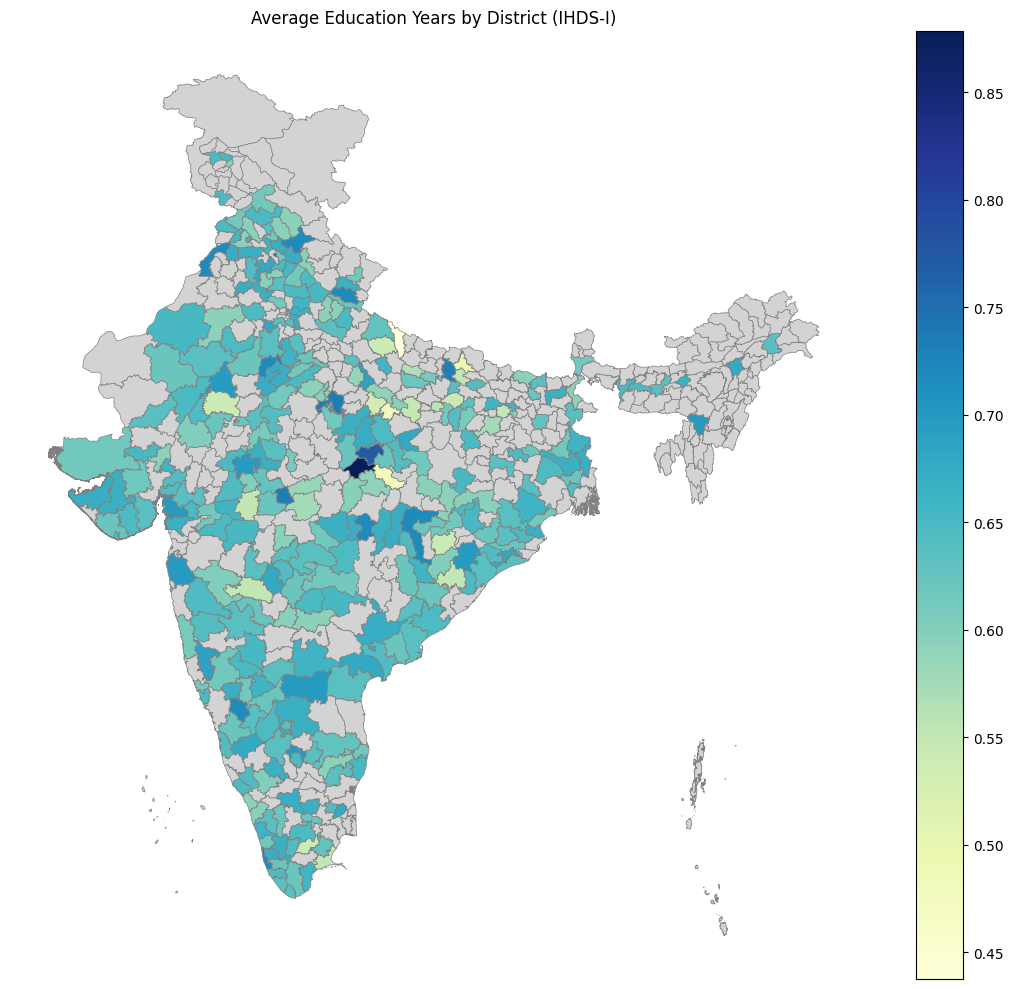

['baramula' 'srinagar' 'pulwama' 'rajauri' 'jammu' 'chamba' 'kangra'
 'kullu' 'mandi' 'hamirpur']
stateid                 int64
distid                  int64
district_name_clean    object
distname               object
state_name             object
merge_key              object
dtype: object


In [45]:
# Load the district shapefile
districts = gpd.read_file("India_districts/2011_Dist.shp")
districts['DISTRICT_clean'] = districts['DISTRICT'].str.lower().str.strip()
districts['ST_NM_clean'] = districts['ST_NM'].str.lower().str.strip()

# Check available columns (often 'DISTRICT', 'DIST_NAME', or similar)
print(districts.columns)
print(districts[['DISTRICT', 'ST_NM', 'geometry']].head())

# Extract distinct mappings
dist_lookup = features[['stateid', 'distid', 'district_name_clean']].drop_duplicates()
# Clean for matching
dist_lookup['distname'] = dist_lookup['district_name_clean'].astype(str).str.lower().str.strip()

# Also clean state names in IHDS to match shapefile
state_lookup = {
    1: 'jammu & kashmir', 2: 'himachal pradesh', 3: 'punjab', 4: 'chandigarh',
    5: 'uttarakhand', 6: 'haryana', 7: 'delhi', 8: 'rajasthan', 9: 'uttar pradesh',
    10: 'bihar', 11: 'sikkim', 12: 'arunachal pradesh', 13: 'nagaland', 14: 'manipur',
    15: 'mizoram', 16: 'tripura', 17: 'meghalaya', 18: 'assam', 19: 'west bengal',
    20: 'jharkhand', 21: 'odisha', 22: 'chhattisgarh', 23: 'madhya pradesh', 24: 'gujarat',
    25: 'daman & diu', 26: 'dadra & nagar haveli', 27: 'maharashtra', 28: 'andhra pradesh',
    29: 'karnataka', 30: 'goa', 31: 'lakshadweep', 32: 'kerala', 33: 'tamil nadu',
    34: 'pondicherry'
}

dist_lookup['state_name'] = dist_lookup['stateid'].map(state_lookup)
dist_lookup['state_name'] = dist_lookup['state_name'].astype(str).str.lower().str.strip()

# Final key for merge
dist_lookup['merge_key'] = dist_lookup['distname'] + '|' + dist_lookup['state_name']
districts['merge_key'] = districts['DISTRICT_clean'] + '|' + districts['ST_NM_clean']

# Merge in distid
districts_merged = districts.merge(dist_lookup[['distid', 'merge_key']], on='merge_key', how='left')

# Merge the feature values
ihds_agg = features.groupby('distid').agg({
    'education_years': 'mean',
    'household_income': 'mean'
}).reset_index()

districts_final = districts_merged.merge(ihds_agg, on='distid', how='left')

# Plot the map
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
districts_final.plot(column='education_years',
                     cmap='YlGnBu',
                     linewidth=0.5,
                     edgecolor='grey',
                     legend=True,
                     missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
                     ax=ax)
plt.title('Average Education Years by District (IHDS-I)')
plt.axis('off')
plt.tight_layout()
plt.show()

print(dist_lookup['distname'].unique()[:10])
print(dist_lookup.dtypes)

327
321
Keys in IHDS: 373
Keys in shapefile: 641
Unmatched example keys (from IHDS):
   tripura|tripura
   fatehgarh|punjab
   south|west bengal
   dadra & nagar haveli|dadra & nagar haveli
   baliya|uttar pradesh
   bhagal pur|bihar
   sarguja|chhattisgarh
   nasik|maharashtra
   delhi municipal corp|delhi
   hissar|haryana
               DISTRICT        ST_NM  distid
230             Hingoli  Maharashtra    16.0
631         Yamunanagar      Haryana     3.0
40             Balangir       Odisha    24.0
272           Kalahandi       Odisha    26.0
573  Thiruvananthapuram       Kerala    14.0
475          Ramanagara    Karnataka     NaN
276           Kandhamal       Odisha    21.0
5                 Ajmer    Rajasthan    21.0
561       Surendranagar      Gujarat     8.0
234               Hugli  West Bengal    12.0


 ['baramula' 'srinagar' 'pulwama' 'rajauri' 'jammu' 'chamba' 'kangra'
 'kullu' 'mandi' 'hamirpur']
stateid                 int64
distid                  int64
district_name_cle

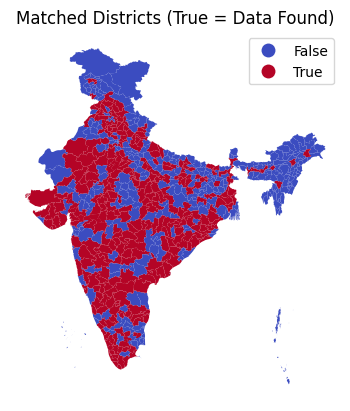

In [46]:
print(districts_merged['distid'].isna().sum())
print(districts_merged['distid'].notna().sum())

# Compare unique keys from both sides
print("Keys in IHDS:", dist_lookup['merge_key'].nunique())
print("Keys in shapefile:", districts['merge_key'].nunique())

# Find examples of unmatched keys
merged_keys = set(dist_lookup['merge_key'])
shapefile_keys = set(districts['merge_key'])
missing_keys = merged_keys - shapefile_keys

print("Unmatched example keys (from IHDS):")
for key in list(missing_keys)[:10]:
    print("  ", key)

print(districts_merged[['DISTRICT', 'ST_NM', 'distid']].sample(10))

districts_final['matched'] = districts_final['education_years'].notna()

print("\n\n", dist_lookup['distname'].unique()[:10])
print(dist_lookup.dtypes)

districts_final.plot(column='matched', cmap='coolwarm', legend=True)
plt.title("Matched Districts (True = Data Found)")
plt.axis('off')
plt.show()